In [7]:
import tensorflow as tf
from models import decoder, encoder, vae
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
from scipy.stats import norm
from hyperparameters import *
from sklearn.model_selection import train_test_split

In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "../data",
    # validation_split=0.2,
    # subset="training",
    seed=123,
    batch_size=16,
    image_size=(64 + 32, 32 + 32),
)

Found 2106 files belonging to 1 classes.


In [9]:
img_processor = tf.keras.layers.CenterCrop(64, 32)

In [10]:
data = []
for images, labels in train_dataset.unbatch():
    data.append(images)
data = np.array(data) / 255

2024-05-07 09:47:59.927462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
x_train_org, x_val_org = train_test_split(data, test_size=0.2, random_state=42)
x_train, x_val = img_processor(x_train_org).numpy(), img_processor(x_val_org).numpy()

In [12]:
encoder_model = encoder.build_encoder(**ENCODER_MODEL_HYPERPARAMETERS)
decoder_model = decoder.build_decoder(**DECODER_MODEL_HYPERPARAMETERS)

vae_model = vae.VAE(encoder_model, decoder_model, reconstruction_loss_weight=50, kl_loss_weight=1)
vae_model.compile(optimizer="adam")

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_reconstruction_loss", patience=5, restore_best_weights=True, mode="min"
)

In [14]:
history_vae_training = vae_model.fit(x_train, epochs=200, batch_size=256, validation_data=x_val, callbacks=[early_stopping])

Epoch 1/200


2024-05-07 09:48:01.036220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - kl_loss: 0.6341 - loss: 70863.1328 - reconstruction_loss: 1417.2500 - val_kl_loss: 3.7825 - val_loss: 70591.5156 - val_reconstruction_loss: 1411.7546
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - kl_loss: 225.0833 - loss: 68814.9922 - reconstruction_loss: 1371.7981 - val_kl_loss: 978.3334 - val_loss: 67010.8438 - val_reconstruction_loss: 1320.6501
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - kl_loss: 324.6140 - loss: 65745.2109 - reconstruction_loss: 1308.4119 - val_kl_loss: 154.3962 - val_loss: 64122.6914 - val_reconstruction_loss: 1279.3660
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - kl_loss: 117.6520 - loss: 63443.2617 - reconstruction_loss: 1266.5122 - val_kl_loss: 78.9308 - val_loss: 60935.0469 - val_reconstruction_loss: 1217.1223
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - kl_loss: 63.9990 - loss: 59768.6680 - reconstruction_loss: 1194.0934 - val_kl_loss: 42.7465 - val_loss: 58654.0664 - val_reconstruction_loss

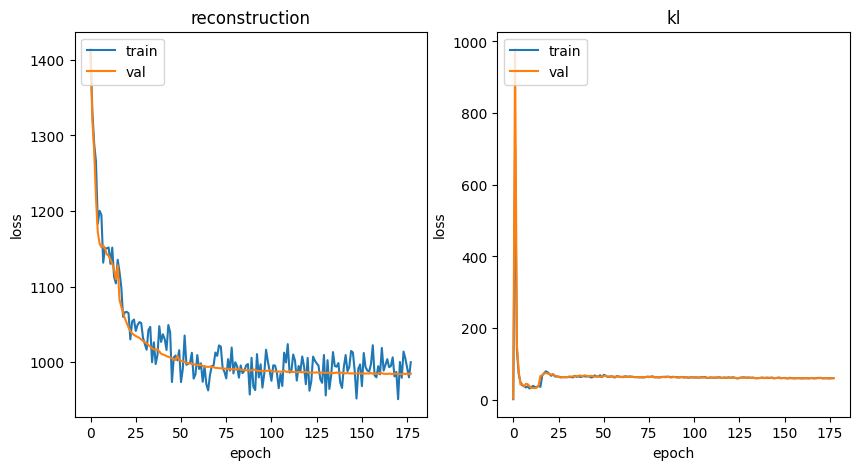

In [15]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(history_vae_training.history["reconstruction_loss"])
plt.plot(history_vae_training.history["val_reconstruction_loss"])
plt.title("reconstruction")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")

plt.subplot(122)
plt.plot(history_vae_training.history["kl_loss"])
plt.plot(history_vae_training.history["val_kl_loss"])
plt.title("kl")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")

plt.show()

In [16]:
_, _, z = encoder_model.predict(x_val)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [17]:
from scipy.cluster.hierarchy import dendrogram
from sklearn import cluster

def plot_dendrogram(mm, **kwargs):
    counts = np.zeros(mm.children_.shape[0])
    n_samples = len(mm.labels_)
    for i, merge in enumerate(mm.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [mm.children_, mm.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

In [18]:
ac = cluster.AgglomerativeClustering(n_clusters=3)

classes = ac.fit_predict(z)

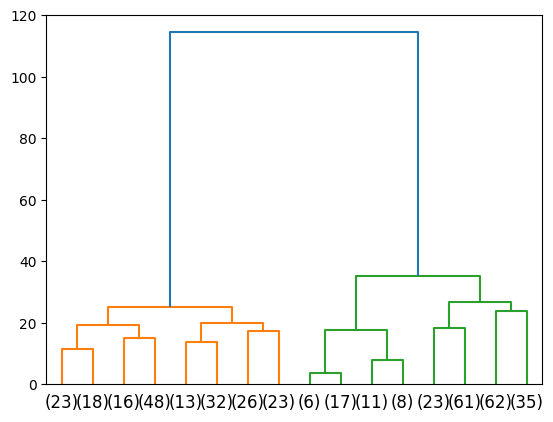

In [19]:
ac2 = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None)
ac2.fit(z)
plot_dendrogram(ac2, truncate_mode="level", p=3)

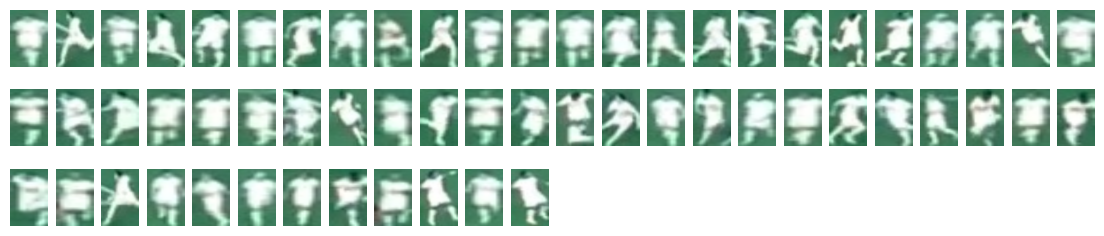

In [23]:
j = 0

plt.figure(figsize=(14, 5))
for i in range(len(classes)):
    if classes[i] == 0:
        plt.subplot(5, 24, j + 1)
        plt.imshow(x_val_org[i])
        plt.axis("off")
        j += 1
    if j == 60:
        break
        
plt.show()

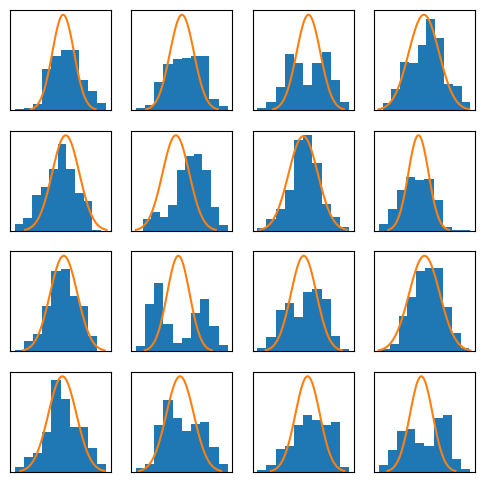

In [21]:
plot_size = int(np.sqrt(LATENT_DIM))

x_vector = np.linspace(-3, 3, 100)
norm_distribution = norm.pdf(x_vector, 0, 1)

plt.figure(figsize=(6, 6))
for i in range(LATENT_DIM):
    plt.subplot(plot_size, plot_size, i + 1)
    plt.hist(z[:, i], density=True)
    plt.plot(x_vector, norm_distribution)
    plt.xticks([])
    plt.yticks([])
plt.show()